In [1]:
import scanpy as sc
import math
import os


# todo: work on imports
import sys
sys.path.append("../")
#from mir.common import parser, Repertoire, SegmentLibrary
#from mir.distances import ClonotypeAligner, AlignGermline
#from mir.comparative import DenseMatch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time
import umap as um
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans,DBSCAN
from sklearn.feature_selection import f_classif
from scipy import stats

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


import scipy.sparse as sp_sparse
#import tables


/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/ykremlyakova/projects/tcr_emb/data/10x/melanoma/10k_human_DTC_Melanoma_5p/raw_feature_bc_matrix'

In [3]:
adata = sc.read_10x_mtx(data_path)

In [4]:
adata.var_names_make_unique()

/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


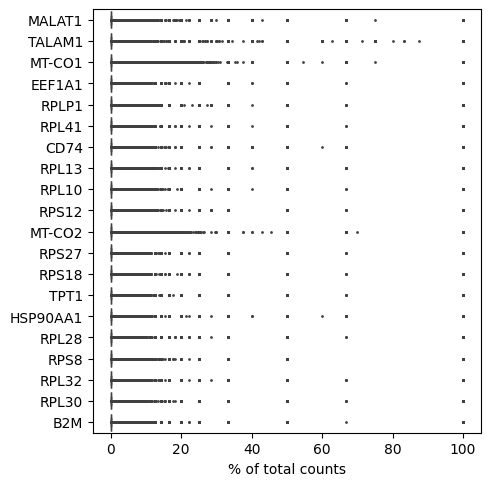

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False)

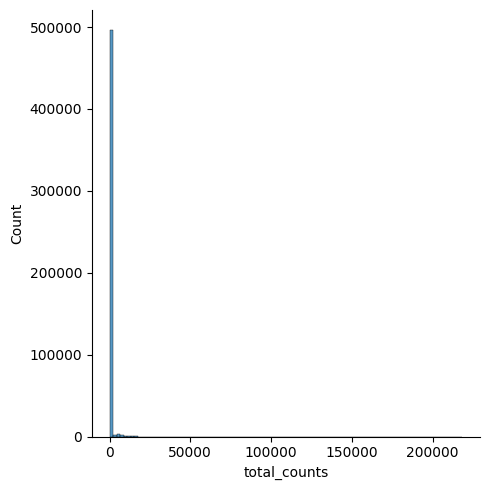

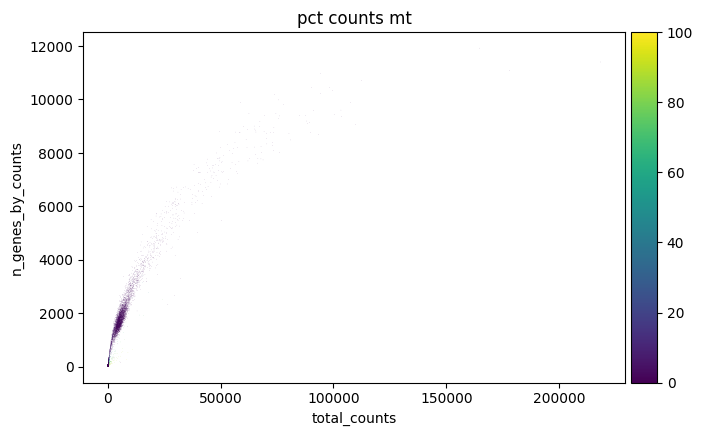

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

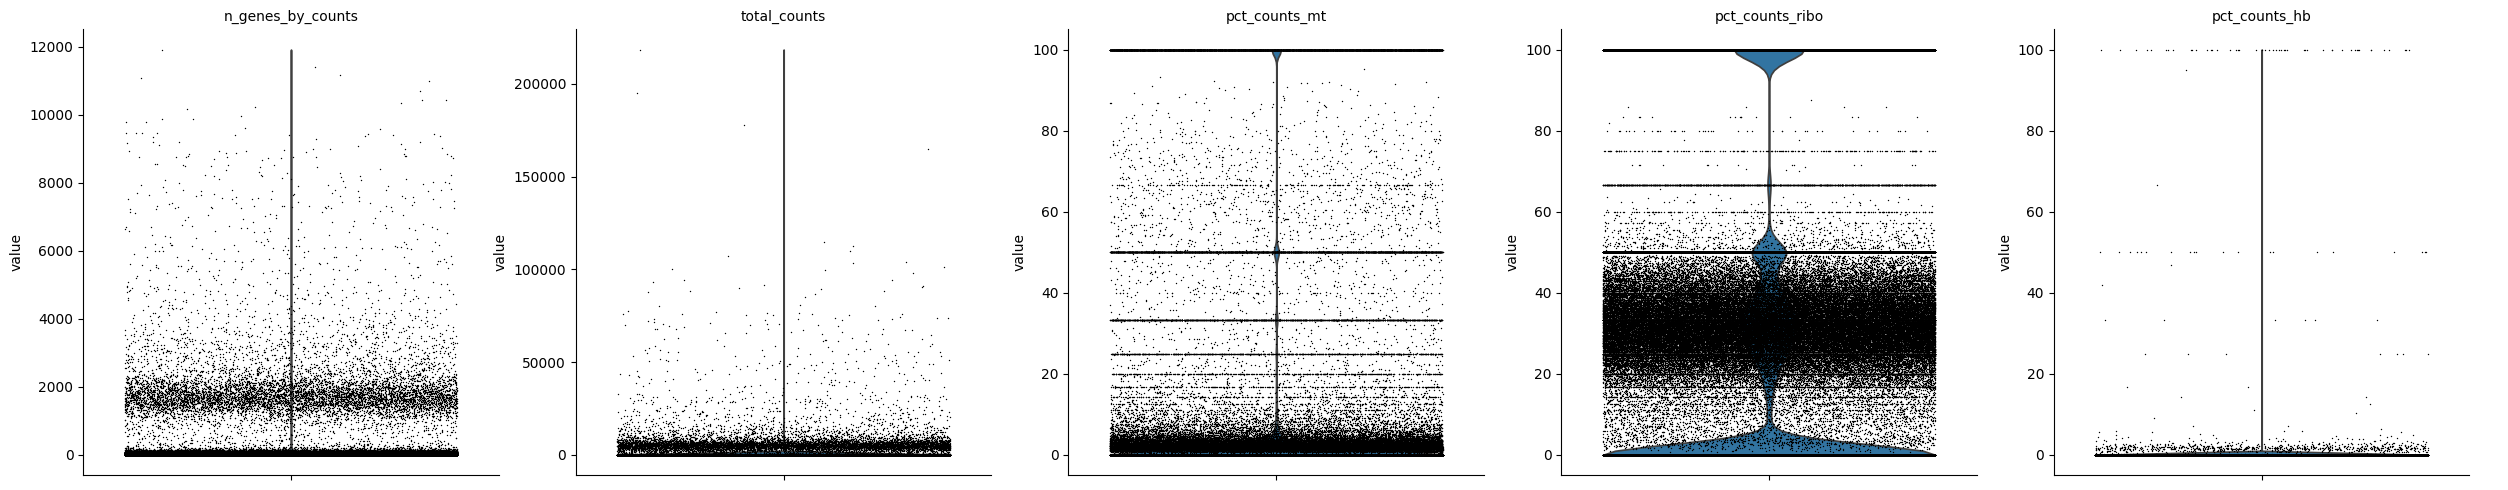

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

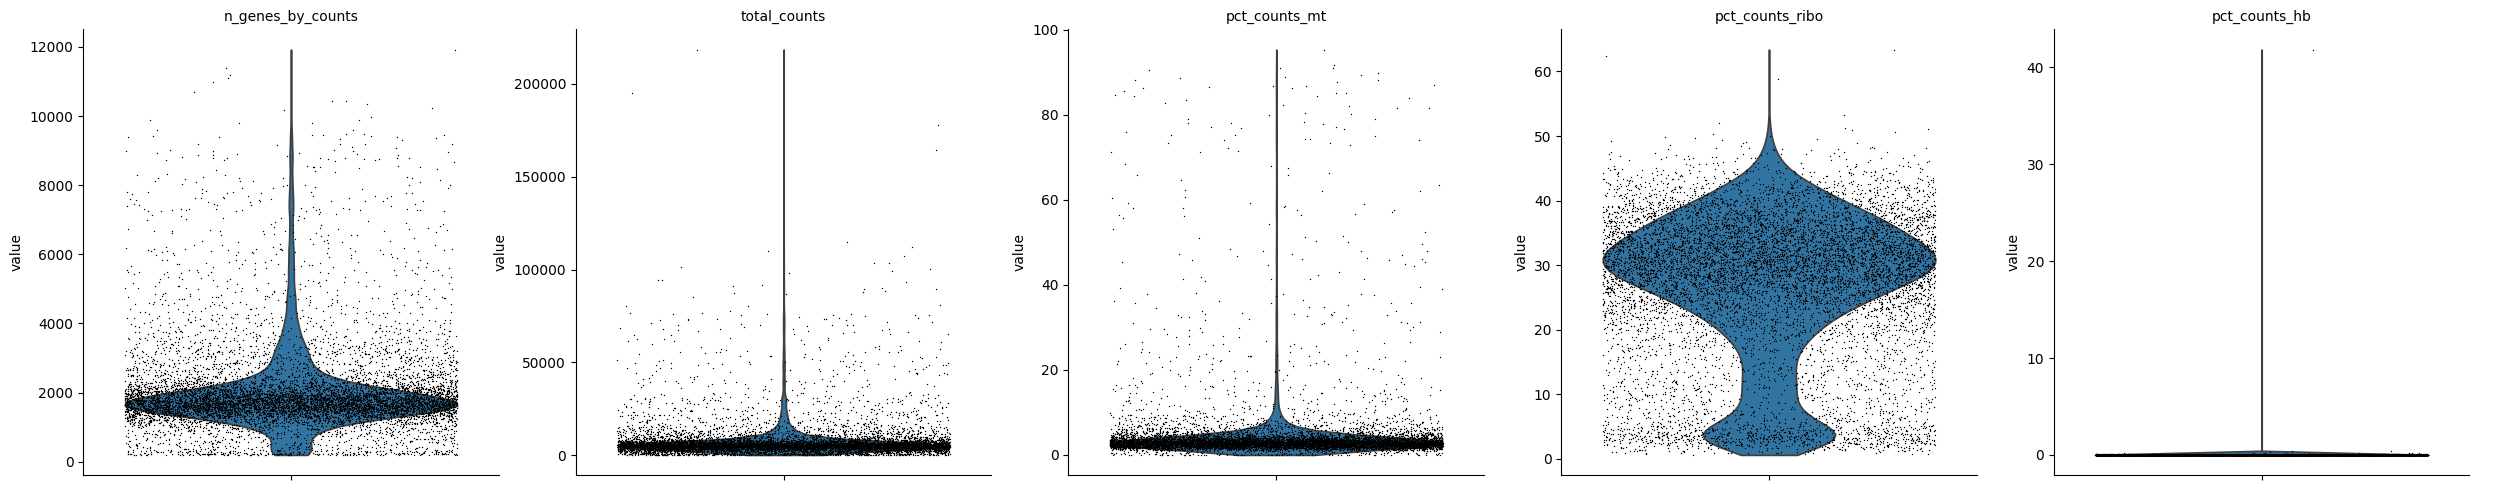

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo','pct_counts_hb'],
             jitter=0.4, multi_panel=True)

In [12]:
print(adata.n_obs, adata.n_vars)

9409 25727


In [13]:
adata.obs["outlier"] = adata.obs.n_genes_by_counts > 5000
adata.obs["mt_outlier"] = adata.obs.pct_counts_mt > 20
adata.obs["ribo_outlier"] = adata.obs.pct_counts_ribo < 3

In [14]:
adata.obs.outlier.value_counts()

False    9036
True      373
Name: outlier, dtype: int64

In [15]:
adata.obs.mt_outlier.value_counts()

False    9173
True      236
Name: mt_outlier, dtype: int64

In [16]:
adata.obs.ribo_outlier.value_counts()

False    9063
True      346
Name: ribo_outlier, dtype: int64

In [17]:
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier) & (~adata.obs.ribo_outlier)].copy()

In [18]:
print(adata.n_obs, adata.n_vars)

8510 25727


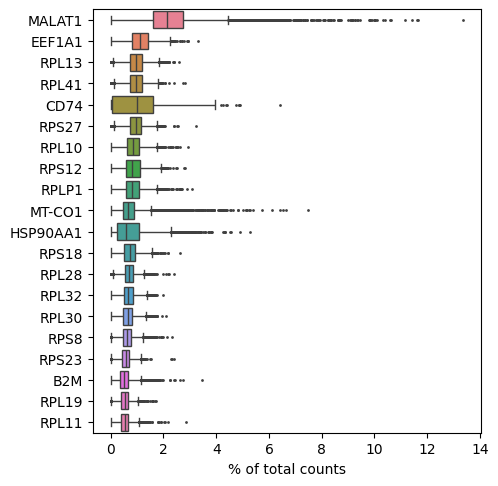

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [20]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, ribo_genes)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

8510 25603


/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


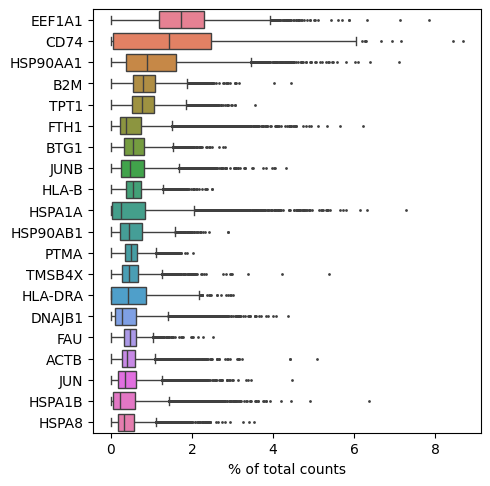

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)


In [23]:
sc.pp.log1p(adata)

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

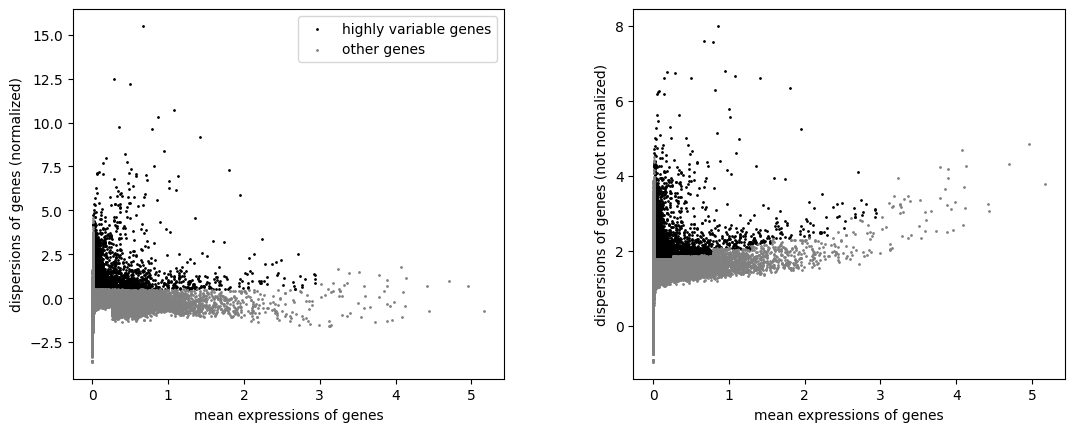

In [25]:
sc.pl.highly_variable_genes(adata)

In [26]:
adata.raw = adata

In [27]:
adata = adata[:, adata.var.highly_variable]

In [28]:
sc.pp.scale(adata, max_value=10)


/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [29]:
sc.tl.pca(adata)

In [30]:
sc.pp.neighbors(adata, n_neighbors=30,n_pcs=10)

In [31]:
sc.tl.umap(adata)

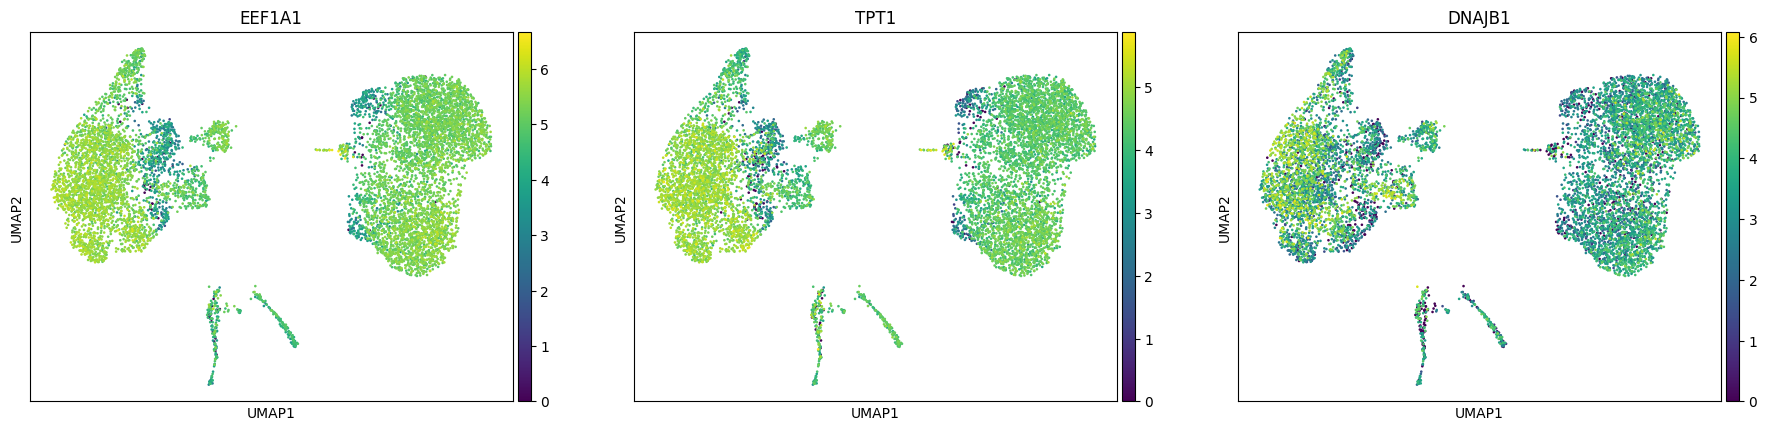

In [32]:
sc.pl.umap(adata, color=["EEF1A1", "TPT1", "DNAJB1"])

In [33]:
sc.tl.tsne(adata, use_rep="X_pca")

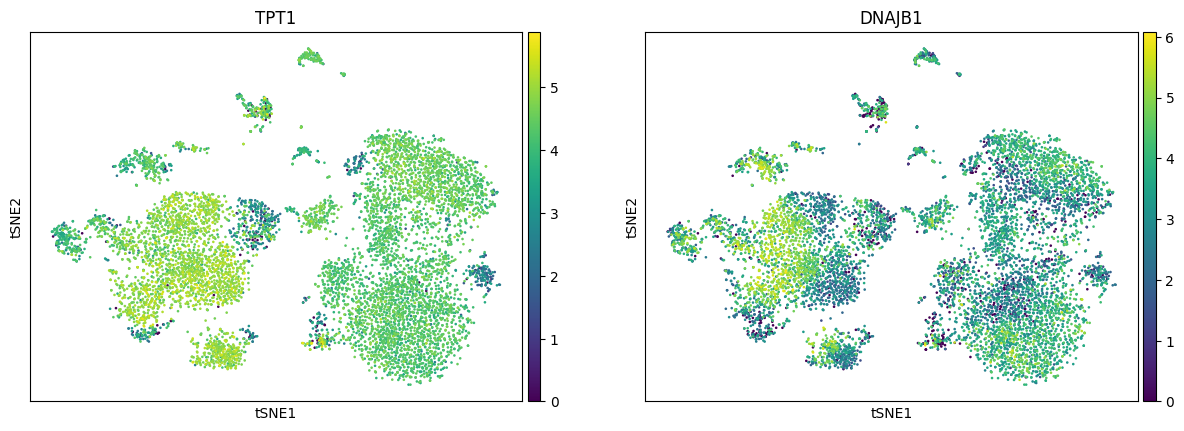

In [34]:
sc.pl.tsne(adata, color=['TPT1',"DNAJB1"])

In [35]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


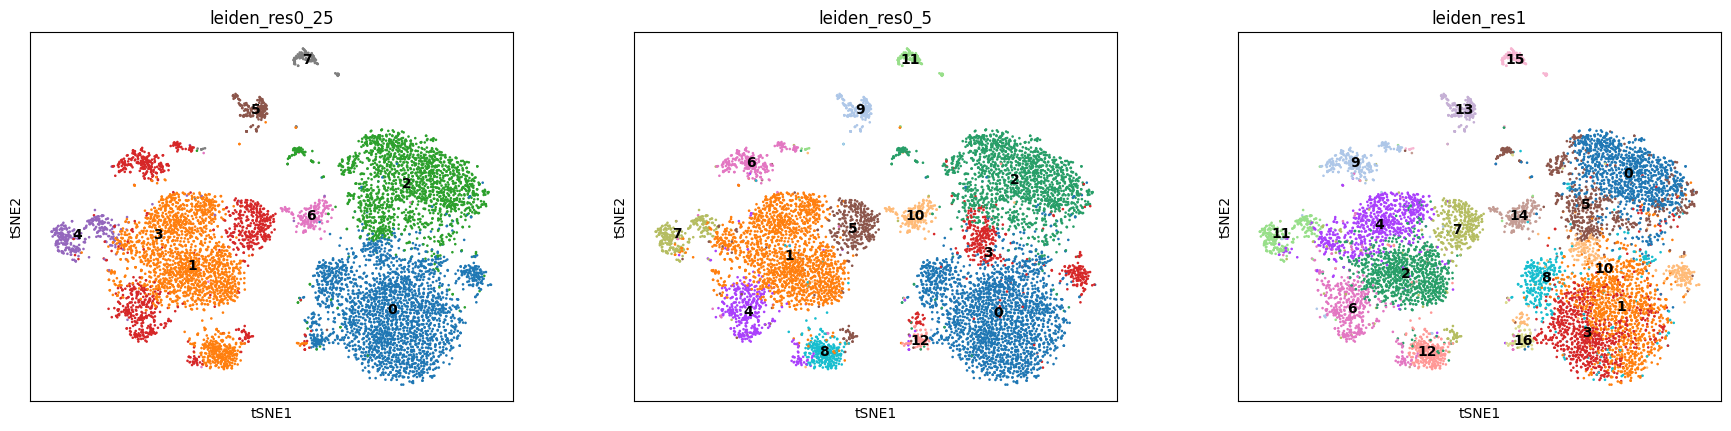

/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


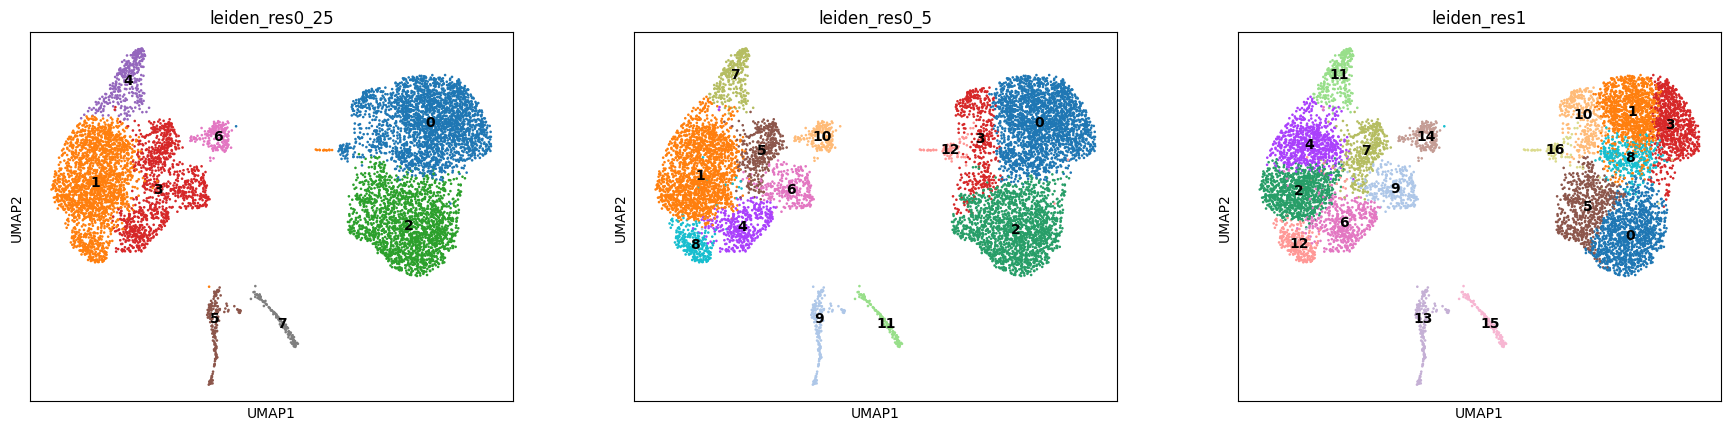

In [47]:
sc.pl.tsne(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [37]:
adata.var.index

Index(['LINC01409', 'HES4', 'ISG15', 'AGRN', 'TNFRSF18', 'TNFRSF4', 'UBE2J2',
       'SCNN1D', 'MXRA8', 'VWA1',
       ...
       'ABCD1', 'RENBP', 'TMEM187', 'TKTL1', 'FLNA', 'ATP6AP1-DT', 'PLXNA3',
       'ENSG00000291032', 'ENSG00000277856', 'ENSG00000275063'],
      dtype='object', length=3623)

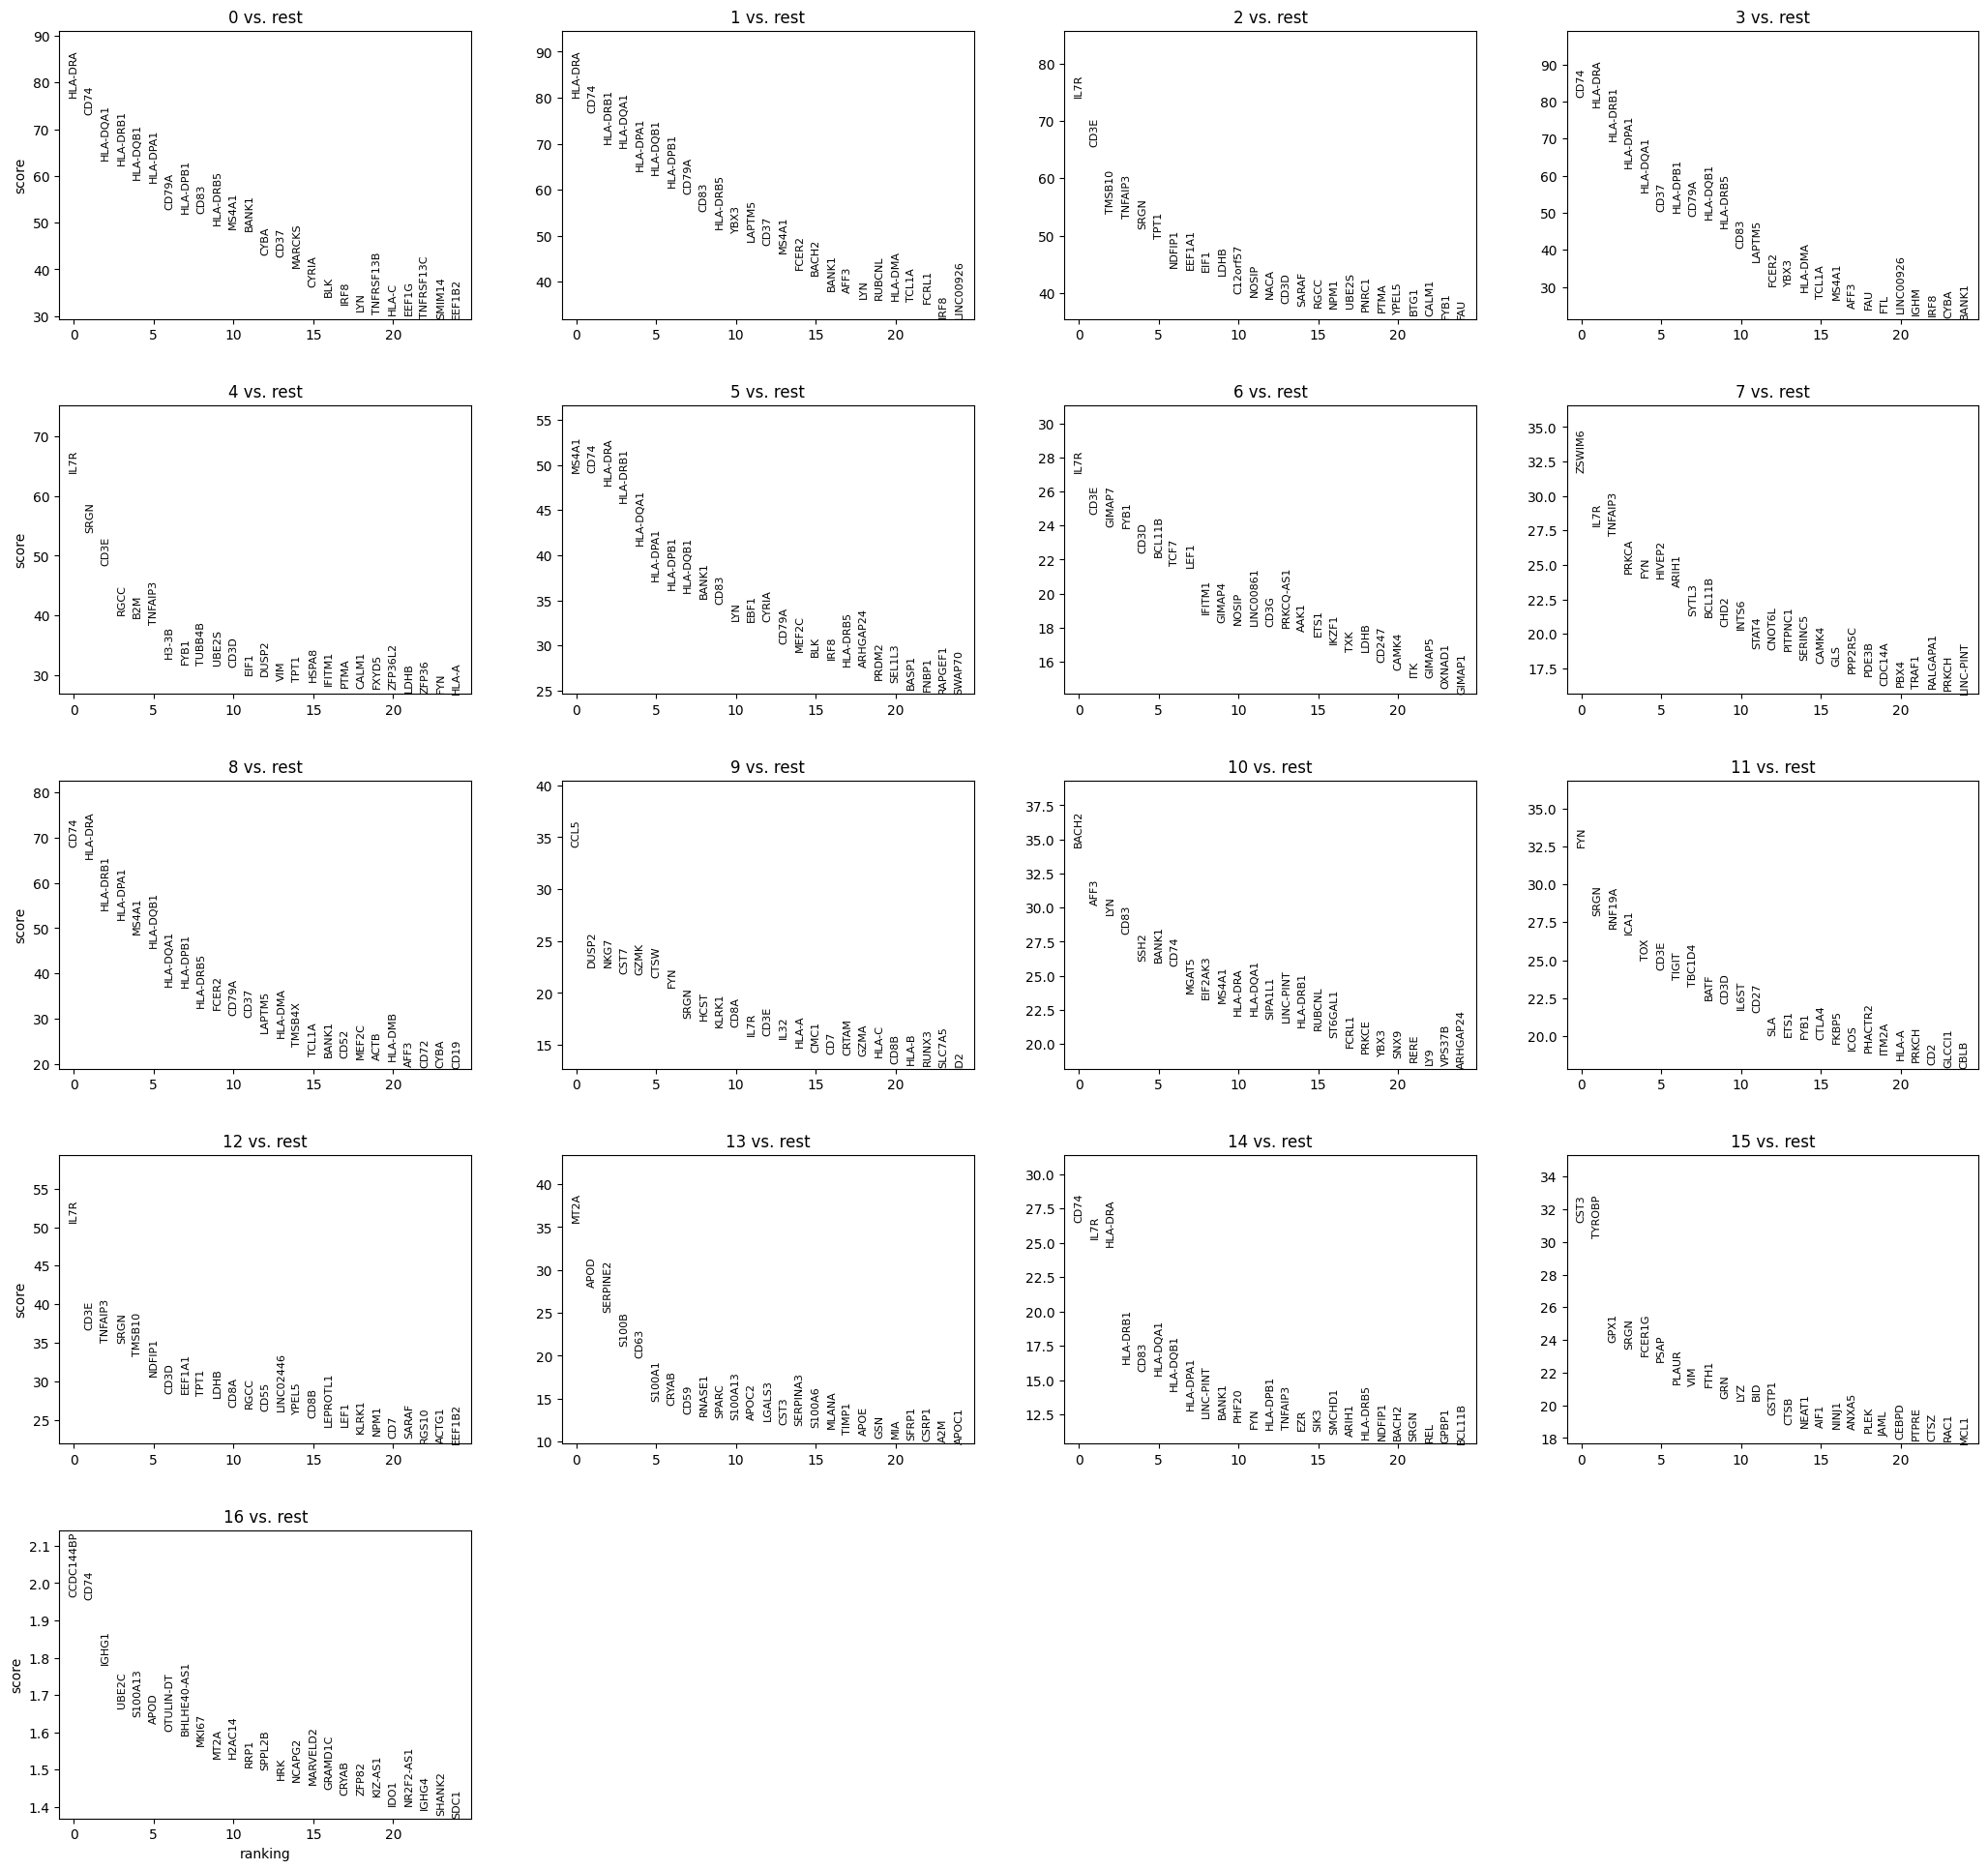

In [38]:
sc.tl.rank_genes_groups(adata, "leiden_res1", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

/home/ykremlyakova/.conda/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


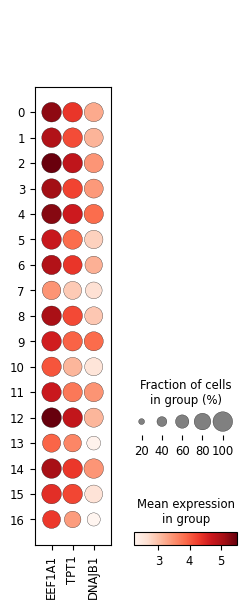

In [40]:
sc.pl.dotplot(adata, ["EEF1A1", "TPT1", "DNAJB1"], "leiden_res1")

In [46]:
sc.tl.rank_genes_groups(adata, "leiden_res1", method="t-test")
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(20)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p
0,HLA-DRA,0.000000e+00,HLA-DRA,0.000000e+00,IL7R,0.000000e+00,CD74,0.000000e+00,IL7R,0.000000e+00,MS4A1,4.408454e-286,IL7R,3.331158e-106,ZSWIM6,3.225531e-117,CD74,0.000000e+00,CCL5,1.353307e-104,BACH2,2.655248e-114,FYN,2.211583e-104,IL7R,1.871704e-181,MT2A,8.664919e-89,CD74,1.338306e-93,CST3,4.191013e-65,CCDC144BP,0.052691
1,CD74,0.000000e+00,CD74,0.000000e+00,CD3E,0.000000e+00,HLA-DRA,0.000000e+00,SRGN,0.000000e+00,CD74,0.000000e+00,CD3E,9.604240e-91,IL7R,2.462073e-102,HLA-DRA,0.000000e+00,DUSP2,5.220909e-69,AFF3,3.687224e-97,SRGN,4.932873e-89,CD3E,1.358490e-120,APOD,8.351651e-71,IL7R,2.923894e-70,TYROBP,2.262124e-63,CD74,0.053660
2,HLA-DQA1,0.000000e+00,HLA-DRB1,0.000000e+00,TMSB10,0.000000e+00,HLA-DRB1,0.000000e+00,CD3E,5.464884e-282,HLA-DRA,0.000000e+00,GIMAP7,1.107098e-84,TNFAIP3,1.149866e-98,HLA-DRB1,4.530846e-299,NKG7,4.847774e-66,LYN,1.596102e-94,RNF19A,6.372749e-83,TNFAIP3,4.803336e-119,SERPINE2,1.324310e-63,HLA-DRA,2.290929e-77,GPX1,1.633742e-52,IGHG1,0.078188
3,HLA-DRB1,0.000000e+00,HLA-DQA1,0.000000e+00,TNFAIP3,0.000000e+00,HLA-DPA1,0.000000e+00,RGCC,1.572919e-207,HLA-DRB1,1.545808e-301,FYB1,3.467017e-86,PRKCA,4.511464e-83,HLA-DPA1,7.399444e-254,CST7,1.126028e-63,CD83,2.214963e-96,ICA1,6.513548e-80,SRGN,2.028727e-123,S100B,1.170685e-52,HLA-DRB1,1.597583e-41,SRGN,9.781748e-53,UBE2C,0.099507
4,HLA-DQB1,0.000000e+00,HLA-DPA1,0.000000e+00,SRGN,0.000000e+00,HLA-DQA1,0.000000e+00,B2M,1.733960e-252,HLA-DQA1,8.955701e-240,CD3D,2.297042e-78,FYN,1.016941e-82,MS4A1,9.750880e-201,GZMK,1.871657e-63,SSH2,1.148942e-81,TOX,1.985112e-74,TMSB10,4.795700e-119,CD63,9.354454e-49,CD83,2.106992e-39,FCER1G,1.486155e-49,S100A13,0.103842
5,HLA-DPA1,0.000000e+00,HLA-DQB1,0.000000e+00,TPT1,0.000000e+00,CD37,0.000000e+00,TNFAIP3,1.046226e-207,HLA-DPA1,3.631023e-205,BCL11B,5.090801e-77,HIVEP2,6.341415e-82,HLA-DQB1,4.631895e-212,CTSW,1.742628e-62,BANK1,3.905558e-83,CD3E,6.729335e-75,NDFIP1,9.660978e-97,S100A1,1.990540e-33,HLA-DQA1,9.398493e-38,PSAP,2.474391e-49,APOD,0.107710
6,CD79A,0.000000e+00,HLA-DPB1,0.000000e+00,NDFIP1,4.306258e-261,HLA-DPB1,0.000000e+00,H3-3B,1.759671e-174,HLA-DPB1,1.092168e-192,TCF7,2.006350e-74,ARIH1,8.925513e-80,HLA-DQA1,9.709100e-161,FYN,1.024580e-60,CD74,1.907780e-92,TIGIT,1.027704e-69,CD3D,3.443471e-89,CRYAB,2.862548e-32,HLA-DQB1,3.950468e-34,PLAUR,8.333520e-46,OTULIN-DT,0.112566
7,HLA-DPB1,0.000000e+00,CD79A,0.000000e+00,EEF1A1,0.000000e+00,CD79A,5.721622e-317,FYB1,4.036597e-152,HLA-DQB1,1.016512e-189,LEF1,9.255660e-74,SYTL3,9.920774e-70,HLA-DPB1,2.364229e-152,SRGN,1.495107e-49,MGAT5,1.893789e-72,TBC1D4,6.733496e-69,EEF1A1,2.449993e-101,CD59,2.990166e-29,HLA-DPA1,3.148926e-29,VIM,7.347630e-47,BHLHE40-AS1,0.114805
8,CD83,0.000000e+00,CD83,0.000000e+00,EIF1,6.898543e-313,HLA-DQB1,0.000000e+00,TUBB4B,2.437480e-157,BANK1,5.051901e-170,IFITM1,8.554510e-61,BCL11B,1.896582e-69,HLA-DRB5,1.887463e-126,HCST,6.609444e-48,EIF2AK3,7.597946e-71,BATF,4.529898e-65,TPT1,7.651077e-99,RNASE1,2.151281e-28,LINC-PINT,1.045015e-26,FTH1,7.810630e-47,MKI67,0.121389
9,HLA-DRB5,0.000000e+00,HLA-DRB5,0.000000e+00,LDHB,3.949160e-262,HLA-DRB5,4.299288e-288,UBE2S,3.493265e-154,CD83,2.810632e-184,GIMAP4,2.652034e-57,CHD2,2.146340e-66,FCER2,1.388649e-113,KLRK1,5.976339e-45,MS4A1,3.065400e-72,CD3D,1.330626e-65,LDHB,9.089362e-89,SPARC,8.900379e-28,BANK1,1.718829e-26,GRN,3.732555e-44,MT2A,0.129605
